# Eager execution

## 1. Setup and basic usage

In [3]:
import os
import tensorflow as tf
import cProfile

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


In [4]:
# In Tensorflow 2.0, eager execution is enabled by default.

tf.executing_eagerly()

True

In [8]:
# Now you can run TensorFlow operations and the results will return immediately:

x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))
m

hello, [[4.]]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.]], dtype=float32)>

In [9]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)
a

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

In [10]:
# Broadcasting support
b = tf.add(a, 1)
print(b)
b

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [4, 5]])>

In [11]:
# Operator overloading is supported
print(a * b)
a * b

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 2,  6],
       [12, 20]])>

In [12]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)
c

[[ 2  6]
 [12 20]]


array([[ 2,  6],
       [12, 20]])

In [13]:
# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]
a.numpy()

[[1 2]
 [3 4]]


array([[1, 2],
       [3, 4]])

## 2. Dynamic control flow

In [14]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [15]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## 3. Eager training

### i. Computing gradients

In [17]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)
grad

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

### ii. Train a model

In [18]:
# The following example creates a multi-layer model that classifies the standard MNIST handwritten digits. 
# It demonstrates the optimizer and layer APIs to build trainable graphs in an eager execution environment.

# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [19]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [20]:
# Even without training, call the model and inspect the output in eager execution:

for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.00667931 -0.00101577  0.0131133   0.01816097  0.00261566  0.02357245
  -0.00789999 -0.00197967  0.00552689 -0.01565534]]


In [21]:
# While keras models have a builtin training loop (using the fit method), 
# sometimes you need more customization. 
# Here's an example, of a training loop implemented with eager:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [22]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [23]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [24]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

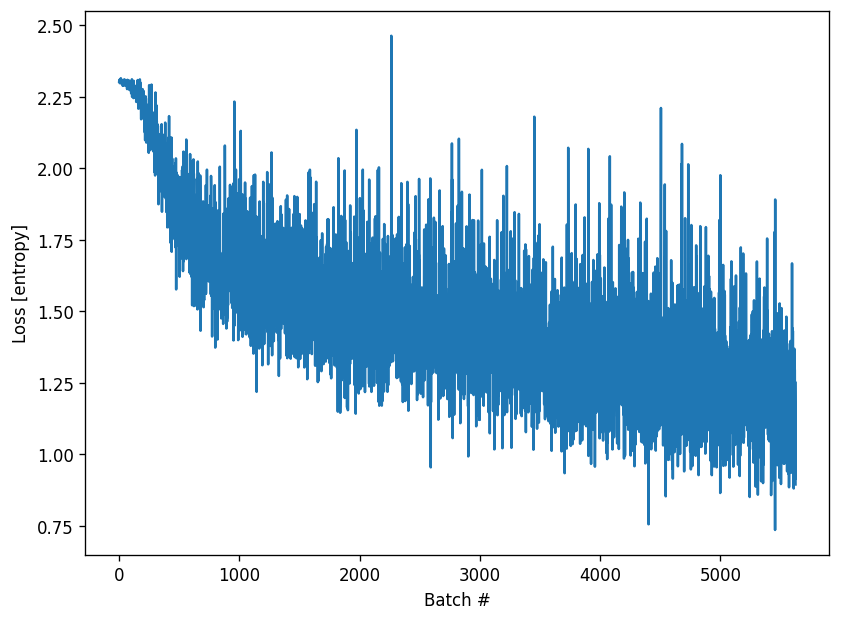

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6), dpi=120)
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### iii. Variables and optimizers

In [27]:
# For example, the automatic differentiation example above can be rewritten:

class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [28]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

In [29]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 70.138
Loss at step 000: 67.363
Loss at step 020: 30.254
Loss at step 040: 13.895
Loss at step 060: 6.683
Loss at step 080: 3.502
Loss at step 100: 2.099
Loss at step 120: 1.480
Loss at step 140: 1.206
Loss at step 160: 1.086
Loss at step 180: 1.032
Loss at step 200: 1.009
Loss at step 220: 0.998
Loss at step 240: 0.994
Loss at step 260: 0.992
Loss at step 280: 0.991


In [30]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 0.990


In [31]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 3.00373911857605, B = 2.0016040802001953


### iv. Object-based saving

In [32]:
# A tf.keras.Model includes a convenient save_weights method allowing you to easily create a checkpoint:

model.save_weights('weights')
status = model.load_weights('weights')

In [33]:
# Using tf.train.Checkpoint you can take full control over this process.
# This section is an abbreviated version of the guide to training checkpoints.

x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [34]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [35]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [36]:
# To save and load models, tf.train.Checkpoint stores the internal state of objects, without requiring hidden variables. 
# To record the state of a model, an optimizer, and a global step, pass them to a tf.train.Checkpoint:

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

### v. Object-oriented metrics

In [38]:
# tf.keras.metrics are stored as objects. 
# Update a metric by passing the new data to the callable, 
# and retrieve the result using the tf.keras.metrics.result method, for example:

m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5

<tf.Tensor: shape=(), dtype=float32, numpy=2.5>

In [39]:
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### vi. Summaries and TensorBoard

In [40]:
# You can use tf.summary to record summaries of variable in eager execution. 
# For example, to record summaries of loss once every 100 training steps:

logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

In [42]:
%ls tb

 驱动器 D 中的卷是 Data
 卷的序列号是 12E0-D62D

 D:\miniconda\workspace\TensorFlow2Gride\tb 的目录

2021/04/04  00:12    <DIR>          .
2021/04/04  00:12    <DIR>          ..
2021/04/04  00:12               669 events.out.tfevents.1617466349.LAPTOP-4SAJKMHC.3664.636583.v2
               1 个文件            669 字节
               2 个目录 318,348,263,424 可用字节


## 4. Advanced automatic differentiation topics

### i. Dynamic models

In [43]:
# tf.GradientTape can also be used in dynamic models. 
# This example for a backtracking line search algorithm looks like normal NumPy code, 
# except there are gradients and is differentiable, despite the complex control flow:

def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### ii. Custom gradients

In [44]:
# Custom gradients are an easy way to override gradients. 
# Within the forward function, define the gradient with respect to the inputs, outputs, or intermediate results. 
# For example, here's an easy way to clip the norm of the gradients in the backward pass:

@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

In [45]:
# Custom gradients are commonly used to provide a numerically stable gradient for a sequence of operations:

def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [46]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [47]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

In [48]:
# Here, the log1pexp function can be analytically simplified with a custom gradient. 
# The implementation below reuses the value for tf.exp(x) that is computed 
# during the forward pass—making it more efficient by eliminating redundant calculations:

@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [49]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [50]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## 5. Performance

In [51]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 0.8437151908874512 secs
GPU: 0.12987542152404785 secs


In [52]:
# A tf.Tensor object can be copied to a different device to execute its operations:

if tf.config.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0
  
# tf.identity is useful when you want to explicitly transport tensor between devices (like, from GPU to a CPU). 
# The return value is not the same Tensor as the original, but contains the same values. 
# This operation is fast when used on the same device.

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.identity instead.


### i. Benchmarks

## 6. Work with functions

# reference

### https://tensorflow.google.cn/guide/eager